In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf
import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3997126922796095871
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40074543104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7882005034692929852
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-08-22 00:07:24.094034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 00:07:25.046364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-08-22 00:07:25.060135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [4]:
imgpath = glob.glob("/home/rabeea/Kvasir/images/*.jpg", recursive = True)
print(len(imgpath))
tr = 700
val = 100
ts = 200
imgpath = sorted(imgpath)
random.Random(42).shuffle(imgpath)
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))

1000
1000 700 100 200


In [5]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    mask_path = "/home/rabeea/Kvasir/masks/" + img_path.split('/')[-1]
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.where(mask>50,255,0)
    mask = cv2.resize(mask.astype(np.uint8),image_size, interpolation = cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],1))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],1),dtype = 'uint8')

        for i in range(len(images_path)):
            #print(images_path[i])
            # Read image and mask
            images_batch[i]= parse_image(images_path[i], self.image_size)
            masks_batch[i] = parse_mask(images_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [6]:
image_size = (256,256)
batch_size = 1

epochs = 350

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,batch_size=batch_size)
valid_gen = DataGen(image_size,valpath, batch_size=batch_size)
test_gen = DataGen(image_size,testpath, batch_size=1)

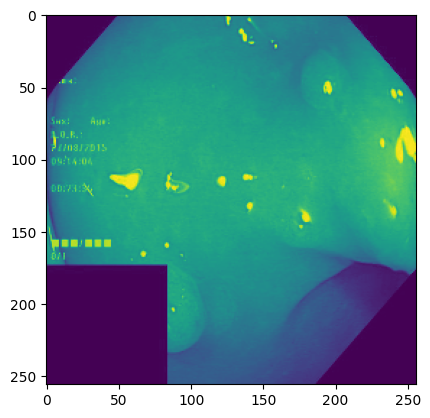

In [7]:
t = train_gen.__getitem__(0)[0]
p = train_gen.__getitem__(0)[1]
plt.imshow(t[0,:,:,0])

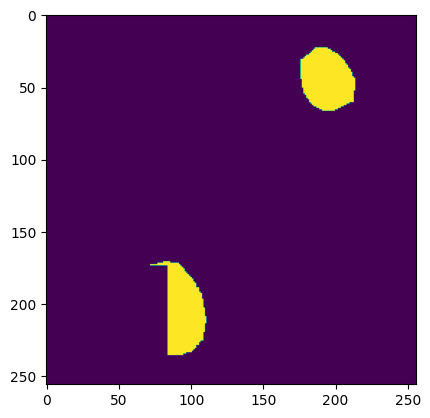

In [8]:
plt.imshow(p[0,:,:,0])

In [9]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [10]:
class attention_unet():
    def __init__(self,img_rows=256,img_cols=256):
        self.img_rows=img_rows
        self.img_cols=img_cols
        self.img_shape=(self.img_rows,self.img_cols,1)
        self.df=64
        self.uf=64
    
    def build_unet(self):
        def conv2d(layer_input,filters,dropout_rate=0,bn=False):
            #d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
            d=layers.Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layer_input)
            #if bn:
            #    d=layers.BatchNormalization()(d)
            #d=layers.Activation('relu')(d)

            d=layers.Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(d)
            #if bn:
            #    d=layers.BatchNormalization()(d)
            #d=layers.Activation('relu')(d)

            if dropout_rate:
                d=layers.Dropout(dropout_rate)(d)

            return d
        def deconv2d(layer_input,filters,bn=False):
            u=layers.UpSampling2D((2,2))(layer_input)
            u=layers.Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
            #if bn:
            #    u=layers.BatchNormalization()(u)
            #u=layers.Activation('relu')(u)

            return u
    
        def attention_block(F_g,F_l,F_int,bn=False):
            g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
            if bn:
                g=layers.BatchNormalization()(g)
            x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
            if bn:
                x=layers.BatchNormalization()(x)
            #    print(g.shape)
            #    print(x.shape)
            psi=layers.Add()([g,x])
            psi=layers.Activation('relu')(psi)
            psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)

            if bn:
                psi=layers.BatchNormalization()(psi)
            psi=layers.Activation('sigmoid')(psi)

            return layers.Multiply()([F_l,psi])
        
        inputs=layers.Input(shape=self.img_shape)
    
        conv1=conv2d(inputs,self.df)
        pool1=layers.MaxPooling2D((2,2))(conv1)

        conv2=conv2d(pool1,self.df*2,bn=True)
        pool2=layers.MaxPooling2D((2,2))(conv2)

        conv3=conv2d(pool2,self.df*4,bn=True)
        pool3=layers.MaxPooling2D((2,2))(conv3)

        conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
        #pool4=layers.MaxPooling2D((2,2))(conv4)

        #conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

#         up6=deconv2d(conv5,self.uf*8,bn=True)
#         conv6=attention_block(up6,conv4,self.uf*8,bn=True)
#         up6=layers.Concatenate()([up6,conv6])
#         conv6=conv2d(up6,self.uf*8)
        
        up7=deconv2d(conv4,self.uf*4,bn=True)
        conv7=attention_block(up7,conv3,self.uf*4,bn=True)
        up7=layers.Concatenate()([up7,conv7])
        conv7=conv2d(up7,self.uf*4)
        
#         up7=deconv2d(conv6,self.uf*4,bn=True)
#         conv7=attention_block(up7,conv3,self.uf*4,bn=True)
#         up7=layers.Concatenate()([up7,conv7])
#         conv7=conv2d(up7,self.uf*4)

        up8=deconv2d(conv7,self.uf*2,bn=True)
        conv8=attention_block(up8,conv2,self.uf*2,bn=True)
        up8=layers.Concatenate()([up8,conv8])
        conv8=conv2d(up8,self.uf*2)
        
        up9=deconv2d(conv8,self.uf,bn=True)
        conv9=attention_block(up9,conv1,self.uf,bn=True)
        up9=layers.Concatenate()([up9,conv9])
        conv9=conv2d(up9,self.uf)

        outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)

        model=Model(inputs=inputs,outputs=outputs)
        
        

        return model

In [10]:
class attention_unet():
    def __init__(self,img_rows=256,img_cols=256):
        self.img_rows=img_rows
        self.img_cols=img_cols
        self.img_shape=(self.img_rows,self.img_cols,1)
        self.df=64
        self.uf=64
    
    def build_unet(self):
        def conv2d(layer_input,filters,dropout_rate=0,bn=False):
            d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
            if bn:
                d=layers.BatchNormalization()(d)
            d=layers.Activation('relu')(d)

            d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
            if bn:
                d=layers.BatchNormalization()(d)
            d=layers.Activation('relu')(d)

            if dropout_rate:
                d=layers.Dropout(dropout_rate)(d)

            return d
        def deconv2d(layer_input,filters,bn=False):
            u=layers.UpSampling2D((2,2))(layer_input)
            u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
            if bn:
                u=layers.BatchNormalization()(u)
            u=layers.Activation('relu')(u)

            return u
    
        def attention_block(F_g,F_l,F_int,bn=False):
            g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
            if bn:
                g=layers.BatchNormalization()(g)
            x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
            if bn:
                x=layers.BatchNormalization()(x)
            #    print(g.shape)
            #    print(x.shape)
            psi=layers.Add()([g,x])
            psi=layers.Activation('relu')(psi)
            psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)

            if bn:
                psi=layers.BatchNormalization()(psi)
            psi=layers.Activation('sigmoid')(psi)

            return layers.Multiply()([F_l,psi])
        
        inputs=layers.Input(shape=self.img_shape)
    
        conv1=conv2d(inputs,self.df)
        pool1=layers.MaxPooling2D((2,2))(conv1)

        conv2=conv2d(pool1,self.df*2,bn=True)
        pool2=layers.MaxPooling2D((2,2))(conv2)

        conv3=conv2d(pool2,self.df*4,bn=True)
        pool3=layers.MaxPooling2D((2,2))(conv3)

        conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
        #pool4=layers.MaxPooling2D((2,2))(conv4)

        #conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

#         up6=deconv2d(conv5,self.uf*8,bn=True)
#         conv6=attention_block(up6,conv4,self.uf*8,bn=True)
#         up6=layers.Concatenate()([up6,conv6])
#         conv6=conv2d(up6,self.uf*8)
        
        up7=deconv2d(conv4,self.uf*4,bn=True)
        conv7=attention_block(up7,conv3,self.uf*4,bn=True)
        up7=layers.Concatenate()([up7,conv7])
        conv7=conv2d(up7,self.uf*4)
        
#         up7=deconv2d(conv6,self.uf*4,bn=True)
#         conv7=attention_block(up7,conv3,self.uf*4,bn=True)
#         up7=layers.Concatenate()([up7,conv7])
#         conv7=conv2d(up7,self.uf*4)

        up8=deconv2d(conv7,self.uf*2,bn=True)
        conv8=attention_block(up8,conv2,self.uf*2,bn=True)
        up8=layers.Concatenate()([up8,conv8])
        conv8=conv2d(up8,self.uf*2)
        
        up9=deconv2d(conv8,self.uf,bn=True)
        conv9=attention_block(up9,conv1,self.uf,bn=True)
        up9=layers.Concatenate()([up9,conv9])
        conv9=conv2d(up9,self.uf)

        outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)

        model=Model(inputs=inputs,outputs=outputs)
        
        

        return model

In [11]:
a=attention_unet()
unet=a.build_unet()
unet.summary()

2023-08-22 00:07:55.351088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

 batch_normalization_3 (BatchNo  (None, 128, 128, 12  512        ['conv2d_15[0][0]']              
 rmalization)                   8)                                                                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 128, 128, 12  512        ['conv2d_16[0][0]']              
 rmalization)                   8)                                                                
                                                                                                  
 add_1 (Add)                    (None, 128, 128, 12  0           ['batch_normalization_3[0][0]',  
                                8)                                'batch_normalization_4[0][0]']  
                                                                                                  
 activation_2 (Activation)      (None, 128, 128, 12  0           ['add_1[0][0]']                  
          

In [12]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "/home/rabeea/logs/attention_unet_polyp/64_4ly_lr4_withoutbn.h5"
#tensorboard = TensorBoard(log_dir='logs/attention_unet_polyp/64_4ly_lr4', histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [12]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "/home/rabeea/logs/attention_unet_polyp/64_4ly_lr4.h5"
tensorboard = TensorBoard(log_dir='logs/attention_unet_polyp/64_4ly_lr4', histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]

In [13]:
unet.compile(loss=dice_loss,
             optimizer=Adam(1e-4),
             metrics=[dice_coef])

In [14]:
history = unet.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350


2023-08-22 00:09:08.378782: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801


700/700 [==============================] - 33s 40ms/step - loss: 0.9762 - dice_coef: 0.0238 - val_loss: 0.9998 - val_dice_coef: 1.9382e-04
Epoch 2/350
700/700 [==============================] - 27s 39ms/step - loss: 0.9998 - dice_coef: 2.4762e-04 - val_loss: 0.9998 - val_dice_coef: 1.9749e-04
Epoch 3/350
700/700 [==============================] - 27s 39ms/step - loss: 0.9998 - dice_coef: 2.4891e-04 - val_loss: 0.9998 - val_dice_coef: 1.9769e-04
Epoch 4/350
700/700 [==============================] - 27s 38ms/step - loss: 0.9998 - dice_coef: 2.4901e-04 - val_loss: 0.9998 - val_dice_coef: 1.9771e-04
Epoch 5/350
 66/700 [=>............................] - ETA: 22s - loss: 0.9998 - dice_coef: 2.0928e-04


KeyboardInterrupt



In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [ ]:
unet.load_weights(filepath)

In [ ]:
print('max val: ',max(history.history['val_dice_coef']))
print('max train: ',max(history.history['dice_coef']))

In [ ]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=unet.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

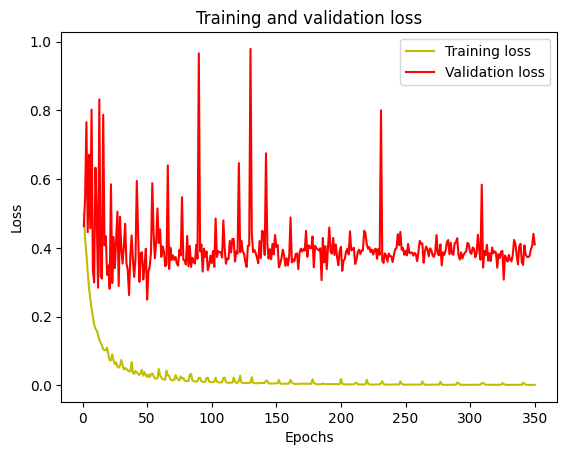

In [15]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

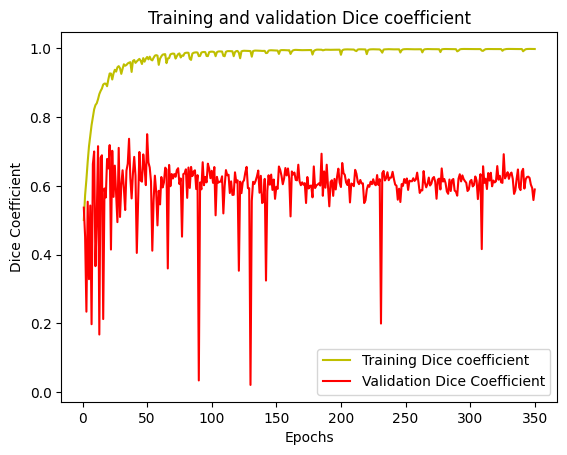

In [16]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [17]:
unet.load_weights(filepath)

In [18]:
print('max val: ',max(history.history['val_dice_coef']))
print('max train: ',max(history.history['dice_coef']))

max val:  0.7506055235862732
max train:  0.9987666606903076


In [20]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=unet.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                   | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_3143296/257209271.py:58: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_3143296/257209271.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|█████████████████

at 0.9: dice:  0.700510188715566
at 0.8: dice:  0.7133664877280583
at 0.7: dice:  0.7204305077168232
at 0.6: dice:  0.725298415301028
at 0.5: dice:  0.7288674255399763
at 0.4: dice:  0.7315854389051905
at 0.3: dice:  0.7332794950733839
at 0.2: dice:  0.7339373823990223
at 0.1: dice:  0.732804277125777
at 0.05: dice:  0.7293892164487886
at 0.01: dice:  0.7040936020007158
